# Ion excitation with a short Fourier-limited Gaussian laser pulse
CERN, 2021

From the Mathematica notebook of Simon Rochester:

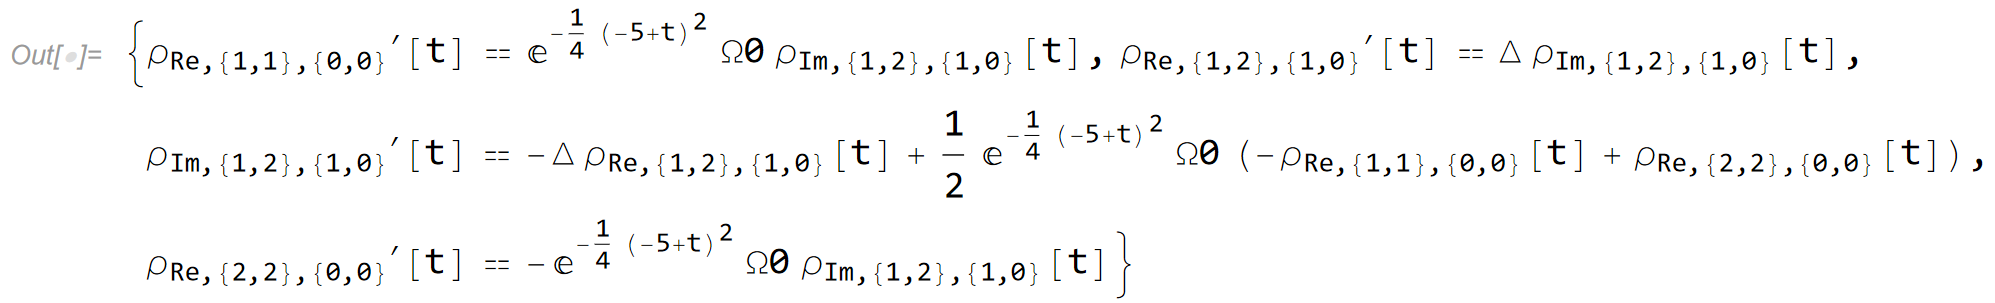

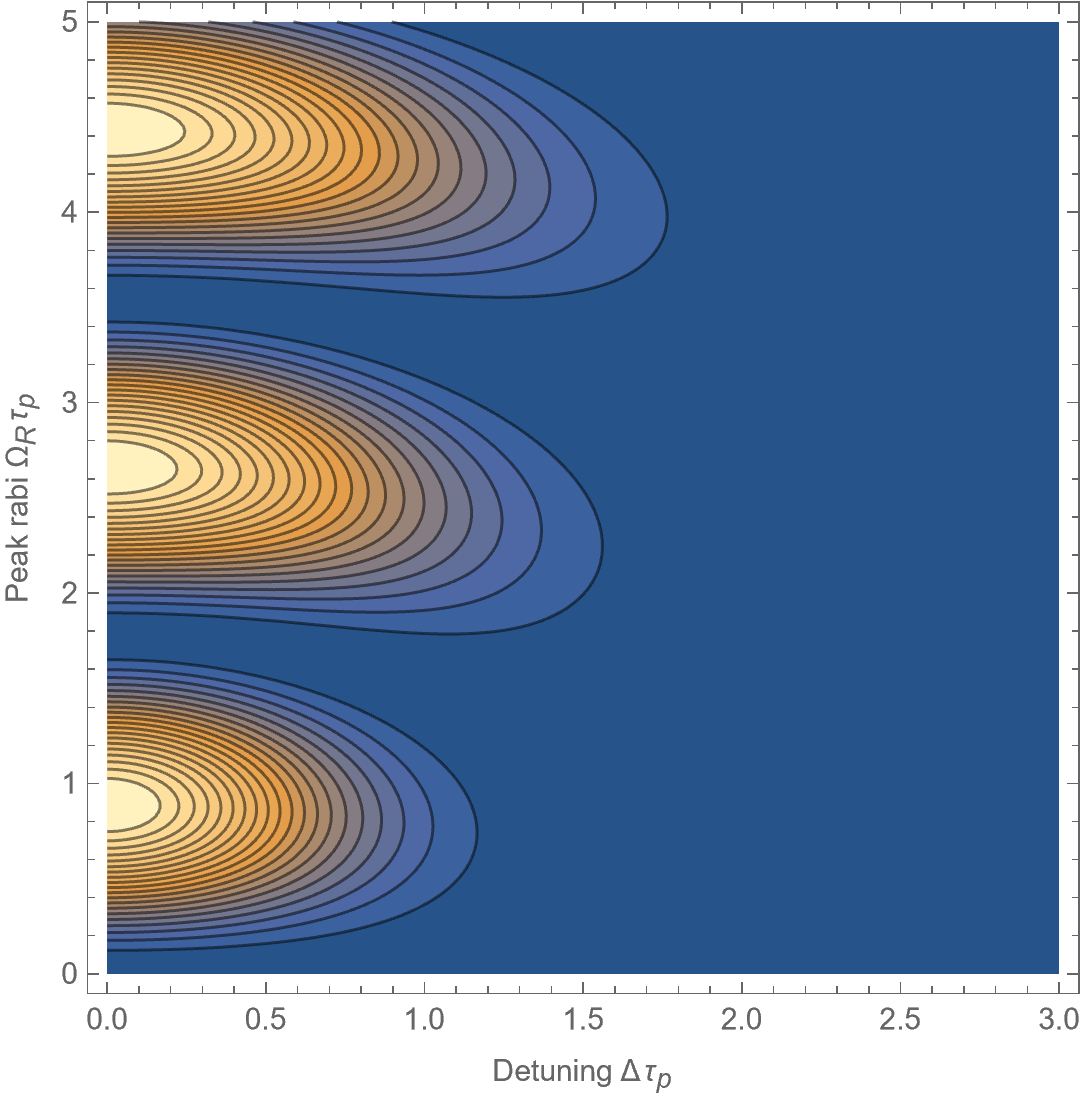

Let's use numeric integration to solve this system of equations:

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

Initial values:

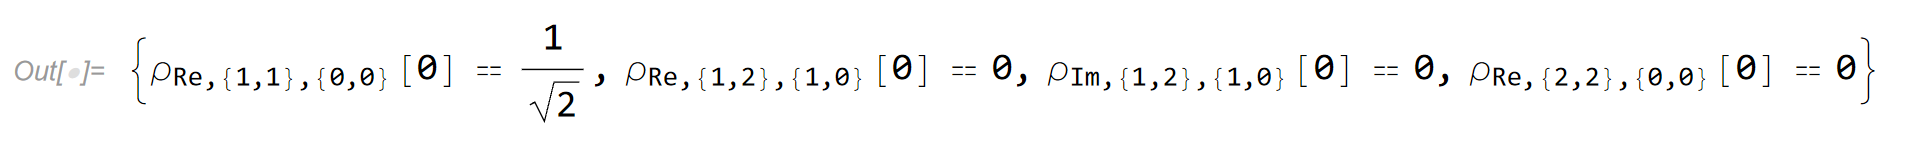

In [2]:
rhoRe1100 = 1/np.sqrt(2);
rhoRe1210 = 0
rhoIm1210 = 0
rhoRe2200 = 0
rho0 = np.array([rhoRe1100,rhoRe1210,rhoIm1210,rhoRe2200])

We solve the equation
$$
\frac{d\boldsymbol{\rho}}{dt} = \boldsymbol{F}(t,\boldsymbol{\rho}).
$$

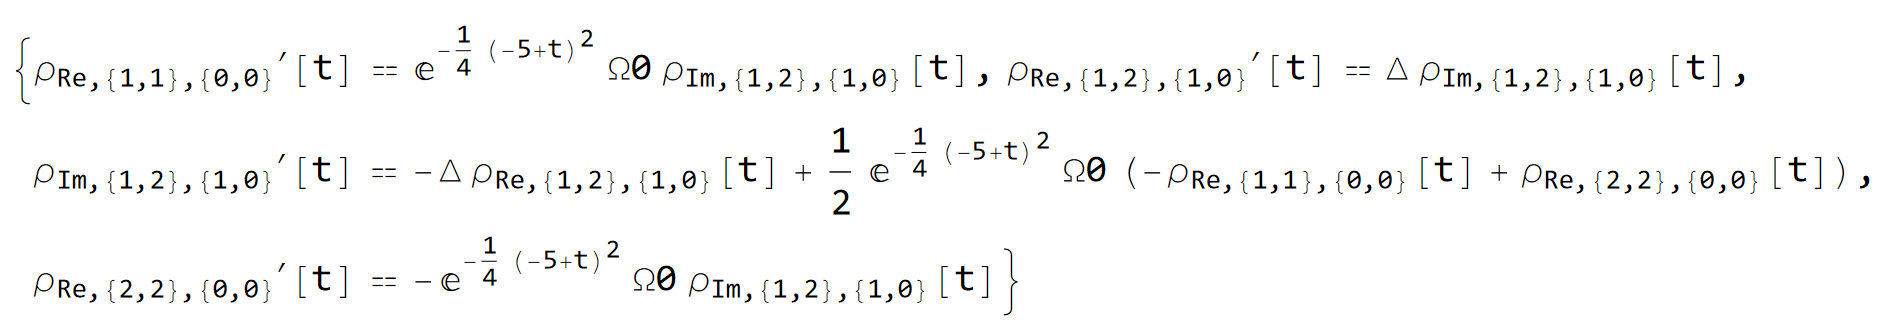

In [3]:
Delta=0; Omega0=5
def F(t,rho):
    # Delta -- Laser frequency detuning from the ion resonance
    # Omega0 -- Peak Raby frequency
    rhoRe1100 = rho[0]
    rhoRe1210 = rho[1]
    rhoIm1210 = rho[2]
    rhoRe2200 = rho[3]
    Exp = np.exp(-(1/4)*(-5+t)**2)
    return np.array([
         Exp*Omega0*rhoIm1210,
         Delta*rhoIm1210,
        -Delta*rhoRe1210 + 0.5*Exp*Omega0*(-rhoRe1100 + rhoRe2200),
        -Exp*Omega0*rhoIm1210
    ])

#F(0,rho0)

In [4]:
t_span = (0, 10) # sec

t_eval = np.linspace(t_span[0], t_span[1], 500) # points of output

In [5]:
%%time
sol = solve_ivp(F, t_span, rho0, t_eval=t_eval, rtol=1e-4)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 23.9 ms


## Plot the evolution

In [6]:
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = pio.templates["simple_white"]
pio.templates.default['layout']['xaxis']['showgrid'] = True
pio.templates.default['layout']['yaxis']['showgrid'] = True

In [7]:
rhoRe1100, rhoRe1210, rhoIm1210, rhoRe2200 = sol.y

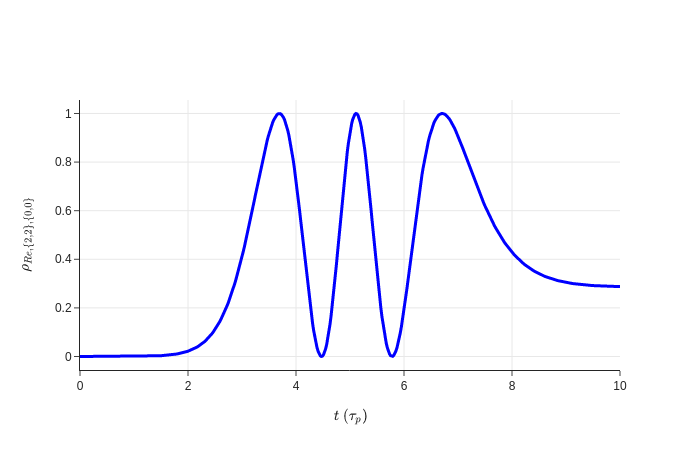

In [8]:
fig = go.Figure()

fig.add_trace( go.Scatter(x=t_eval, y=rhoRe2200*np.sqrt(2), mode='lines',
                          line_width=3, line_color="blue"))

fig.update_xaxes(title_text=r"$t\ (\tau_p)$")
fig.update_yaxes(title_text=r"$\rho_{Re,\{2,2\},\{0,0\}}$")

fig.show(renderer="png")

## Map of resulting excitation as a function of $\Delta_d$ and $\Omega_0$

In [9]:
def excite_ion(newDelta,newOmega0):
    global Delta;  Delta  = newDelta
    global Omega0; Omega0 = newOmega0
    sol = solve_ivp(F, t_span, rho0, rtol=1e-4)
    rhoRe1100, rhoRe1210, rhoIm1210, rhoRe2200 = sol.y
    return rhoRe2200[-1]*np.sqrt(2)

excite_ion(0,5)

0.28754312119778763

In [10]:
Delta_range  = np.linspace(0, +3, 30)
Omega0_range = np.linspace(0, +8, 80)
Deltas, Omega0s = np.meshgrid(Delta_range, Omega0_range)

In [11]:
%%time
Excitation = np.vectorize(excite_ion)(Deltas, Omega0s)

CPU times: user 16.9 s, sys: 4 ms, total: 16.9 s
Wall time: 16.9 s


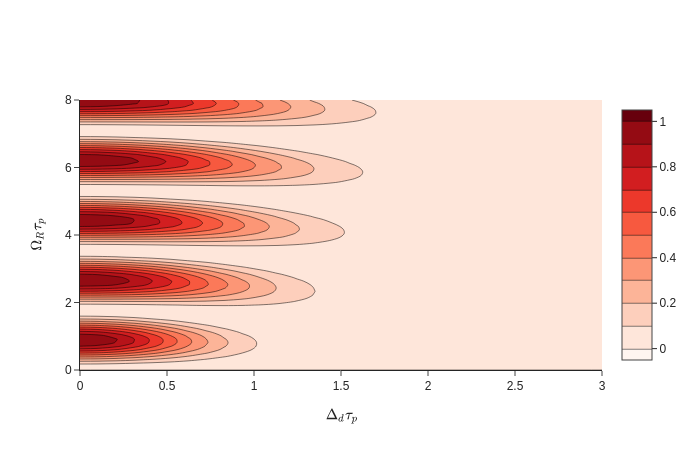

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z=Excitation,
        x=Delta_range, # horizontal axis
        y=Omega0_range, # vertical axis
        zmin=0.0,
        zmax=1.0,
        colorscale='reds',
        contours=dict(
            start=0,
            end=1,
            size=0.1,
        ),        
    ))

fig.update_xaxes(title_text=r"$\Delta_d\tau_p$")
fig.update_yaxes(title_text=r"$\Omega_R\tau_p$")

fig.show(renderer="png")

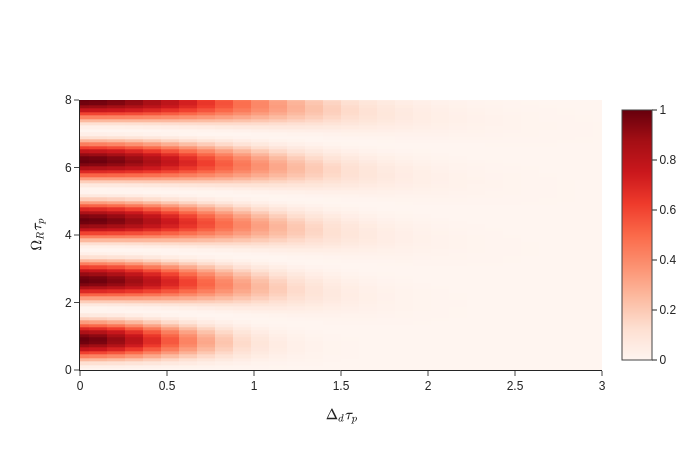

In [13]:
# Heatmap version:
fig = go.Figure(data =
    go.Heatmap(
        z=Excitation,
        x=Delta_range, # horizontal axis
        y=Omega0_range, # vertical axis
        zmin=0.0,
        zmax=1.0,
        colorscale='reds', 
    ))

fig.update_xaxes(range=(0,Delta_range[-1]), title_text=r"$\Delta_d\tau_p$")
fig.update_yaxes(range=(0,Omega0_range[-1]), title_text=r"$\Omega_R\tau_p$")

fig.show(renderer="png")

In [14]:
import json

# Saving data

with open('map_of_excitation.json', "w") as f:
    json.dump({
        'Delta_detuning*tau_pulse max': Delta_range[-1],
        'OmegaRabi*tau_pulse max': Omega0_range[-1],
        'Excitation probability': Excitation.tolist()
    }, f, indent=1)

print('Saved.')

Saved.


Data structure:

In [15]:
Excitation

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.18411486e-02, 3.11740685e-02, 2.92431335e-02, ...,
        2.70355845e-08, 2.28077803e-08, 1.90833067e-08],
       [1.23324438e-01, 1.20716395e-01, 1.13213305e-01, ...,
        6.68340089e-08, 5.65184103e-08, 4.75037145e-08],
       ...,
       [8.99833344e-01, 8.93388745e-01, 8.74250460e-01, ...,
        1.29302055e-03, 6.50777145e-04, 2.78266613e-04],
       [9.79716109e-01, 9.71707997e-01, 9.48001909e-01, ...,
        6.11484906e-04, 2.39648211e-04, 6.23609984e-05],
       [9.98484224e-01, 9.89379208e-01, 9.62482380e-01, ...,
        1.58124787e-04, 2.46104446e-05, 5.56436309e-06]])

In [16]:
np.shape(Excitation)

(80, 30)

In [17]:
Deltas

array([[0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ],
       [0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ],
       [0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ],
       ...,
       [0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ],
       [0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ],
       [0.        , 0.10344828, 0.20689655, ..., 2.79310345, 2.89655172,
        3.        ]])

In [18]:
Omega0s

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10126582, 0.10126582, 0.10126582, ..., 0.10126582, 0.10126582,
        0.10126582],
       [0.20253165, 0.20253165, 0.20253165, ..., 0.20253165, 0.20253165,
        0.20253165],
       ...,
       [7.79746835, 7.79746835, 7.79746835, ..., 7.79746835, 7.79746835,
        7.79746835],
       [7.89873418, 7.89873418, 7.89873418, ..., 7.89873418, 7.89873418,
        7.89873418],
       [8.        , 8.        , 8.        , ..., 8.        , 8.        ,
        8.        ]])